# Entregable Práctico - Aprendizaje No Supervisado

In [ ]:
# Importacion de librerias

# Basicas
import pandas as pd
import numpy as np 
import time

# Entrenamiento
from sklearn.cluster import KMeans,MeanShift, AgglomerativeClustering
from sklearn import decomposition
from scipy.cluster.hierarchy import dendrogram
from sklearn import (manifold, preprocessing, decomposition)

# Metricas
from sklearn.metrics import silhouette_samples, silhouette_score

# Visualizacion
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.tools as tls
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib.cm as cm

In [ ]:
# Carga de la base players_21.csv 

# Para apertura del dataset desde Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

def connect_to_drive():
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  return GoogleDrive(gauth)

def read_csv_from_drive(drive, id, filename):
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(filename)  
  return pd.read_csv(filename)

drive = connect_to_drive()  # utilización de la función de apertura de archivos desde drive

In [ ]:
data = read_csv_from_drive(drive, '1i1f-4p8h4lMwWiPvyXkgz6_FrhvvZHC2', 'player_21.csv') # el 2° parámetro es el id del archivo (terminación del link en drive)
data.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,...,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,33,1987-06-24,170,72,Argentina,FC Barcelona,Spain Primera Division,1.0,93,93,67500000,560000,"RW, ST, CF",Left,5,4,4,Medium/Low,Messi,Yes,138400000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...",CAM,10.0,NaN,2004-07-01,2021.0,RW,10.0,85.0,92.0,91.0,95.0,38.0,65.0,NaN,...,44,40,93,95,75,96,NaN,35,24,6,11,15,14,8,89+3,89+3,89+3,92+0,93+0,93+0,93+0,92+0,93+0,93+0,93+0,91+2,87+3,87+3,87+3,91+2,66+3,65+3,65+3,65+3,66+3,62+3,52+3,52+3,52+3,62+3
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,35,1985-02-05,187,83,Portugal,Juventus,Italian Serie A,1.0,92,92,46000000,220000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,75900000.0,"#Aerial Threat, #Dribbler, #Distance Shooter, ...",LS,7.0,NaN,2018-07-10,2022.0,LS,7.0,89.0,93.0,81.0,89.0,35.0,77.0,NaN,...,63,29,95,82,84,95,NaN,32,24,7,11,15,14,11,91+1,91+1,91+1,89+0,91+0,91+0,91+0,89+0,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,54+3,54+3,54+3,61+3
2,200389,https://sofifa.com/player/200389/jan-oblak/210002,J. Oblak,Jan Oblak,27,1993-01-07,188,87,Slovenia,Atlético Madrid,Spain Primera Division,1.0,91,93,75000000,125000,GK,Right,3,3,1,Medium/Medium,PLAYER_BODY_TYPE_259,Yes,159400000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,...,34,19,11,65,11,68,NaN,12,18,87,92,78,90,90,33+3,33+3,33+3,32+0,35+0,35+0,35+0,32+0,38+3,38+3,38+3,35+3,38+3,38+3,38+3,35+3,32+3,36+3,36+3,36+3,32+3,32+3,33+3,33+3,33+3,32+3
3,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,31,1988-08-21,184,80,Poland,FC Bayern München,German 1. Bundesliga,1.0,91,91,80000000,240000,ST,Right,4,4,4,High/Medium,PLAYER_BODY_TYPE_276,Yes,132000000.0,"#Distance Shooter, #Clinical Finisher",ST,9.0,NaN,2014-07-01,2023.0,NaN,NaN,78.0,91.0,78.0,85.0,43.0,82.0,NaN,...,81,49,94,79,88,88,NaN,42,19,15,6,12,8,10,89+2,89+2,89+2,85+0,87+0,87+0,87+0,85+0,85+3,85+3,85+3,83+3,79+3,79+3,79+3,83+3,64+3,65+3,65+3,65+3,64+3,61+3,60+3,60+3,60+3,61+3
4,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,28,1992-02-05,175,68,Brazil,Paris Saint-Germain,French Ligue 1,1.0,91,91,90000000,270000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,166500000.0,"#Speedster, #Dribbler, #Playmaker, #FK Special...",LW,10.0,NaN,2017-08-03,2022.0,NaN,NaN,91.0,85.0,86.0,94.0,36.0,59.0,NaN,...,51,36,87,90,92,93,NaN,30,29,9,9,15,15,11,84+3,84+3,84+3,90+0,89+0,89+0,89+0,90+0,90+1,90+1,90+1,90+1,83+3,83+3,83+3,90+1,67+3,62+3,62+3,62+3,67+3,62+3,49+3,49+3,49+3,62+3


## 1. Análisis Exploratorio 


El dataset contiene información del FIFA 21 de 18.944 jugadores con 106 atributos. Algunos de estos atributos consisten en la posicion que ocupa en el club en el que juega y en su equipo nacional asi como tambien estadisticas como habilidades de ataque, defensa, "mentalidad", habilidades de arquero, entre otras. 

Algunos de los atributos (detallaremos aquellos menos intuitivos) son:

1. `sofifa_id`: identificador unico para cada jugador. 
2. `overall`: desempeño general del jugador. Se calcula utilizando otras variables de desempeño general. Asume valores del 47 al 93.
3. `potential`: potencial del jugador. 
4. `player_positions`: posicion en la que juega. Estas pueden ser: LS (Left Striker), ST (Striker), RS (Right Striker), LW (Left Winger), LF (Left Forward), CF (Centre Forward), RF (Right Forward), RW (Right Winger), LAM (Left Attacking Midfielder), CAM (Attacking Midfielder), RAM (Right Attacking Midfielder), LM (Left Midfielder), LCM (Left Centre Midfielder), CM (Centre Midfielder), RCM (Right Centre Midfielder), RM (Right Midfielder), LWB (Left Wing-Back), LDM (Left Defensive Midfielder), CDM (Defensive Midfielder), RDM (Right Defensive Midfielder), RWB (Right Wing back), LB (Left-Back), LCB (Left Centre-Back), CB (Centre-Back), RCB (Right Centre-Back), RB (Right-Back), GK (Goalkeeper).
5. En relacion a las habilidades de los jugadores, se tienen relacionadas al ataque, a la defensa, al ataje, de movimiento, de potencia y de "mentalidad" lo que puede interpretarse como de estrategia/plan en el juego. 


In [ ]:
# Tamaño del dataset
data.shape

(18944, 106)

Existen valores nulos en las columnas: 'club_name', 'league_name', 'league_rank', 'release_clause_eur', 'player_tags', 'team_position', 'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until', 'nation_position', 'nation_jersey_number', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking','gk_reflexes', 'gk_speed', 'gk_positioning', 'player_traits', 'defending_marking'

In [ ]:
# Nos quedamos con las primeras 80 columnas:
data_1 = data.iloc[:, :80]
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18944 entries, 0 to 18943
Data columns (total 80 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sofifa_id                   18944 non-null  int64  
 1   player_url                  18944 non-null  object 
 2   short_name                  18944 non-null  object 
 3   long_name                   18944 non-null  object 
 4   age                         18944 non-null  int64  
 5   dob                         18944 non-null  object 
 6   height_cm                   18944 non-null  int64  
 7   weight_kg                   18944 non-null  int64  
 8   nationality                 18944 non-null  object 
 9   club_name                   18719 non-null  object 
 10  league_name                 18719 non-null  object 
 11  league_rank                 18719 non-null  float64
 12  overall                     18944 non-null  int64  
 13  potential                   189

In [ ]:
# Variables con valores faltantes
temp = data_1.isna().sum().reset_index()
temp = temp[temp[0] != 0]
temp["index"].unique()

array(['club_name', 'league_name', 'league_rank', 'release_clause_eur',
       'player_tags', 'team_position', 'team_jersey_number',
       'loaned_from', 'joined', 'contract_valid_until', 'nation_position',
       'nation_jersey_number', 'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking',
       'gk_reflexes', 'gk_speed', 'gk_positioning', 'player_traits',
       'defending_marking'], dtype=object)

El objetivo de este trabajo es analizar si existen grupos (clusters) que puedan identificarse a partir del estudio de ciertas habilidades. Por lo tanto, las variables mas importantes a tener en cuenta seran aquellas que reflejen scores de habilidades para cada jugador (por ello nos quedamos con las primeras 80 columnas). 

Algunas cuestiones interesantes a resolver seran:
1. Relación entre habilidades. 
2. Mejores y peores jugadores determinados en función de los scores otorgados. 
3. Posiciones de los jugadores y balanceo. 



La variable ```overall``` (score que indica el desempeño general del jugador) tiene una distribución que concentra mayores valores en torno al 60 y 70. Vemos que la cola derecha se extiende hasta scores de más de 90, que pertenecen a los denominados mejores jugadores. La cola izquierda, con valores por debajo de 50 es más acotada ya que no se tienen demasiados jugadores por debajo de dicho valor, estos estarian asociados a los peores jugadores del dataset. 



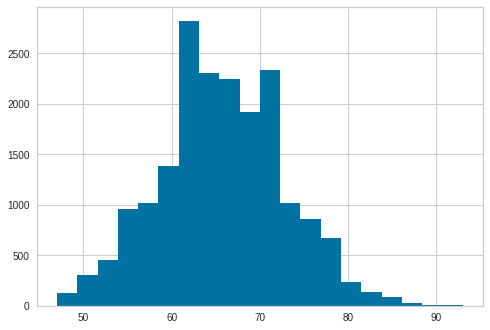

In [ ]:
# Distribución de la variable Overall. 
data_1['overall'].hist(bins = 20)

In [ ]:
data_1['overall'].describe() # Util para seleccion de datos en analisis grafico. 

count    18944.000000
mean        65.677787
std          7.002278
min         47.000000
25%         61.000000
50%         66.000000
75%         70.000000
max         93.000000
Name: overall, dtype: float64

In [ ]:
# Mejores jugadores segun Overall. 
mejores = data_1.sort_values(by = "overall", ascending = False)
mejores = mejores[["short_name", "club_name", "overall"]].head(20)
mejores

,short_name,club_name,overall
0,L. Messi,FC Barcelona,93
1,Cristiano Ronaldo,Juventus,92
2,J. Oblak,Atlético Madrid,91
3,R. Lewandowski,FC Bayern München,91
4,Neymar Jr,Paris Saint-Germain,91
5,K. De Bruyne,Manchester City,91
9,Alisson,Liverpool,90
10,S. Mané,Liverpool,90
11,M. Salah,Liverpool,90
8,V. van Dijk,Liverpool,90


In [ ]:
# Peores jugadores segun Overall
peores = data_1.sort_values(by = "overall", ascending = True)
peores = peores[["short_name", "club_name", "overall"]].head(10)
peores

,short_name,club_name,overall
18943,Song Yue,Tianjin TEDA FC,47
18928,V. Da Silva,Oldham Athletic,47
18929,B. Hough,Oldham Athletic,47
18930,R. McKinley,Derry City,47
18931,M. Flores,Club Bolívar,47
18932,F. Cárdenas,Club Bolívar,47
18933,Zhou Xiao,Dalian YiFang FC,47
18934,Wang Zhen'ao,Dalian YiFang FC,47
18942,Chen Zitong,Shijiazhuang Ever Bright F.C.,47
18936,Zhong Jiyu,Shijiazhuang Ever Bright F.C.,47


Podemos ver cuales son los clubes mejor valorados según el ```overall``` de sus jugadores.

In [ ]:
club_avg_overall=data_1.groupby("club_name")["overall"].mean().reset_index().sort_values("overall",ascending=False)
club_avg_overall.head(8)

,club_name,overall
216,FC Bayern München,81.045455
489,Real Madrid,79.250000
131,Chelsea,79.212121
214,FC Barcelona,78.909091
374,Liverpool,78.575758
330,Inter,78.000000
387,Manchester United,77.818182
386,Manchester City,77.484848


La variable ```age``` hace referencia a la edad de los jugadores. Se puede ver que la cantidad de jugadores en actividad empieza a caer fuertemente despues de los 30. Hay muy pocos que llegan a jugar hasta despues de los 40 años.

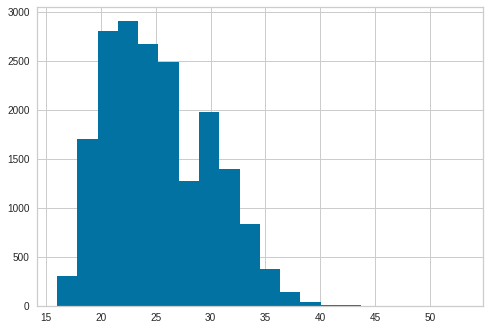

In [ ]:
data_1['age'].hist(bins = 20)

**Posiciones de juego. Generacion de nueva variable**

Existen numerosas posiciones de juego en la variable `player_positions` por lo que reduciremos esa clasificación a cuatro tipos: arquero (GK - GoalKeeper), defensor (D - Defender), delantero (S - Striker) y mediocampista (MF - MidFielder). El objetivo de esta nueva clasificación es poder agrupar e identificar de forma más rápida las posiciones de forma general, para analizar si los clusters responden a estas posiciones agrupadas o si existen clusters a nivel de sub divisiones. A su vez, para el análisis gráfico, es útil cruzar esta información al comparar las distintas habilidades. 

In [ ]:
map_posiciones = {"ST" : "S", "LS" : "S", "RS" : "S", "CF" : "MF", "LW" : "S", "LF" : "S", "RF" : "S", "RW" : "S", "LAM" : "MF", "CAM" : "MF", "RAM" : "MF", "LF" : "MF", "LCM" : "MF", "CM" : "MF", "RCM" : "MF", "RM" : "MF", "LWB" : "D", "LDM" : "D", "CDM" : "D", "RDM" : "D", "RWB" : "D", "LB" : "D",  "LCB" : "D", "CB" : "D", "RCB" : "D", "RB" : "D", "GK" : "GK", "LM" : "MF", "SUB" : "S", "RES" : "MF", "MD" : "MF"}

data_1["Posición"] = data_1["team_position"].map(map_posiciones)

In [ ]:
# Eliminamos los registros que tengan Nan´s en team_position. 
data_2 = data_1.drop(data_1[data_1["team_position"].isna()].index, axis = 0)
data_2

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,...,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,Posición
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,33,1987-06-24,170,72,Argentina,FC Barcelona,Spain Primera Division,1.0,93,93,67500000,560000,"RW, ST, CF",Left,5,4,4,Medium/Low,Messi,Yes,138400000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...",CAM,10.0,NaN,2004-07-01,2021.0,RW,10.0,85.0,92.0,91.0,95.0,38.0,65.0,NaN,...,NaN,NaN,NaN,NaN,"Finesse Shot, Long Shot Taker (AI), Speed Drib...",85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,NaN,35,24,6,11,15,14,8,MF
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,35,1985-02-05,187,83,Portugal,Juventus,Italian Serie A,1.0,92,92,46000000,220000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,75900000.0,"#Aerial Threat, #Dribbler, #Distance Shooter, ...",LS,7.0,NaN,2018-07-10,2022.0,LS,7.0,89.0,93.0,81.0,89.0,35.0,77.0,NaN,...,NaN,NaN,NaN,NaN,"Power Free-Kick, Flair, Long Shot Taker (AI), ...",84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,NaN,32,24,7,11,15,14,11,S
2,200389,https://sofifa.com/player/200389/jan-oblak/210002,J. Oblak,Jan Oblak,27,1993-01-07,188,87,Slovenia,Atlético Madrid,Spain Primera Division,1.0,91,93,75000000,125000,GK,Right,3,3,1,Medium/Medium,PLAYER_BODY_TYPE_259,Yes,159400000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,...,78.0,90.0,52.0,90.0,"GK Long Throw, Comes For Crosses",13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,NaN,12,18,87,92,78,90,90,GK
3,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,31,1988-08-21,184,80,Poland,FC Bayern München,German 1. Bundesliga,1.0,91,91,80000000,240000,ST,Right,4,4,4,High/Medium,PLAYER_BODY_TYPE_276,Yes,132000000.0,"#Distance Shooter, #Clinical Finisher",ST,9.0,NaN,2014-07-01,2023.0,NaN,NaN,78.0,91.0,78.0,85.0,43.0,82.0,NaN,...,NaN,NaN,NaN,NaN,"Solid Player, Finesse Shot, Outside Foot Shot,...",71,94,85,84,89,85,79,85,70,88,77,78,77,93,82,89,84,76,86,85,81,49,94,79,88,88,NaN,42,19,15,6,12,8,10,S
4,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,28,1992-02-05,175,68,Brazil,Paris Saint-Germain,French Ligue 1,1.0,91,91,90000000,270000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,166500000.0,"#Speedster, #Dribbler, #Playmaker, #FK Special...",LW,10.0,NaN,2017-08-03,2022.0,NaN,NaN,91.0,85.0,86.0,94.0,36.0,59.0,NaN,...,NaN,NaN,NaN,NaN,"Injury Prone, Flair, Speed Dribbler (AI), Outs...",85,87,62,87,87,95,88,89,81,95,94,89,96,91,83,80,62,81,50,84,51,36,87,90,92,93,NaN,30,29,9,9,15,15,11,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

La mayoria de los jugadores que tenemos en el dataset juegan como delanteros, seguidos de los mediocampistas. Es lógico que la cantidad de arqueros sea mucho menor.

In [ ]:
data_2["Posición"].value_counts()

S     9318
MF    5291
D     3429
GK     681
Name: Posición, dtype: int64

In [ ]:
# Seleccionamos las habilidades de los jugadores
skills = ['weak_foot', 'skill_moves', 'shooting',
       'passing', 'dribbling', 'defending', 'physic', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed',
       'gk_positioning', 'player_traits', 'attacking_crossing',
       'attacking_finishing', 'attacking_heading_accuracy',
       'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
       'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
       'movement_agility', 'movement_reactions', 'movement_balance',
       'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
       'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking', 'defending_standing_tackle',
       'defending_sliding_tackle', 'goalkeeping_diving',
       'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes', 'overall']

In [ ]:
len(skills) # Se tienen 49 habilidades 

49

In [ ]:
# Matriz de correlación entre habilidades:
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

corr_matrix = data_2[skills].corr()

pio.templates.default = "plotly_white"

heat = go.Heatmap(
    z=corr_matrix,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale=px.colors.diverging.RdBu,
    zmin=-1,
    zmax=1)

layout = go.Layout(
    title_text="Matriz de Correlación entre habilidades", 
    title_x=0.5, 
    width=1000, 
    height=1000,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    yaxis_autorange='reversed'
)

fig=go.Figure(data=[heat], layout=layout)
fig.show(renderer="colab")

Lo que se observa en la matriz de correlación es

* Las habilidades relacionadas a la posición de arquero, tienen muy alta correlación positiva entre ellas (mayor al 0.90); lo que no sucede en tal magnitud para el resto de las posiciones. 
* Las habilidades relacionadas al ataque (posición delantera) tienen una correlación negativa muy alta con las habilidades de arqueros. 
* Vemos muchas "manchas blancas", lo que indicaria que 2 habilidades no tienen relación alguna entre si. Sin embargo, estas se deben a valores faltantes en las variables. 

## 2. Análisis Gráfico 


In [ ]:
# Preparacion de datos para visualizar: 
  # Se seleccionan los jugadores con un overall score superior al cuantil 75. 
data_3 = data_2.sample(n = 10000)[data_2["overall"] > 70] # Obtenido de la tabla describe del analisis exploratorio
data_3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,...,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,Posición
3831,241607,https://sofifa.com/player/241607/tomas-belmont...,T. Belmonte,Tomás Belmonte,22,1998-05-27,178,68,Argentina,Club Atlético Lanús,Argentina Primera División,1.0,71,82,3800000,9000,"CDM, CM",Right,1,4,3,Medium/Medium,Lean,No,6500000.0,NaN,SUB,13.0,NaN,2017-10-28,2023.0,NaN,NaN,68.0,61.0,63.0,69.0,68.0,76.0,NaN,...,NaN,NaN,NaN,NaN,NaN,59,57,79,71,59,67,53,43,67,73,67,69,67,71,65,69,81,83,70,59,81,69,71,59,59,71,NaN,73,65,6,12,9,5,12,S
3692,215053,https://sofifa.com/player/215053/matias-zaldiv...,M. Zaldivia,Matías Ezequiel Zaldivia,29,1991-01-22,181,79,Argentina,Colo-Colo,Chilian Campeonato Nacional,1.0,72,72,2600000,500,CB,Right,1,4,2,Medium/Medium,Normal,No,5700000.0,NaN,RES,4.0,NaN,2016-01-21,2021.0,NaN,NaN,51.0,39.0,61.0,59.0,72.0,78.0,NaN,...,NaN,NaN,NaN,NaN,"Injury Prone, Dives Into Tackles (AI)",64,32,71,65,41,60,44,35,65,60,55,48,44,73,51,47,83,78,80,39,73,72,57,60,41,75,NaN,72,74,8,14,6,8,12,MF
2860,190748,https://sofifa.com/player/190748/yasin-oztekin...,Y. Öztekin,Yasin Öztekin,33,1987-03-19,179,70,Turkey,Sivasspor,Turkish Süper Lig,1.0,73,73,2400000,15000,"LM, RM",Right,1,3,3,High/Low,Lean,No,4800000.0,NaN,SUB,10.0,NaN,2020-01-13,2021.0,NaN,NaN,78.0,71.0,69.0,73.0,45.0,66.0,NaN,...,NaN,NaN,NaN,NaN,"Long Shot Taker (AI), Speed Dribbler (AI)",64,71,57,72,61,71,71,62,66,74,77,79,79,73,78,75,79,66,61,71,74,37,75,71,63,70,NaN,40,42,10,16,7,11,13,S
4062,247144,https://sofifa.com/player/247144/dino-hotic/21...,D. Hotić,Dino Hotić,24,1995-07-26,168,69,Bosnia Herzegovina,KSV Cercle Brugge,Belgian Jupiler Pro League,1.0,71,74,3000000,8000,"RW, CAM",Left,1,4,3,High/Medium,Normal,No,4600000.0,NaN,RW,10.0,NaN,2020-01-06,2023.0,NaN,NaN,81.0,61.0,73.0,71.0,40.0,73.0,NaN,...,NaN,NaN,NaN,NaN,"Finesse Shot, Long Shot Taker (AI), Playmaker ...",70,54,44,67,39,68,76,71,77,78,86,77,56,64,88,71,58,80,71,71,73,29,72,81,51,72,NaN,43,52,9,10,6,15,12,S
2807,178051,https://sofifa.com/player/178051/lucas-deaux/2...,L. Deaux,Lucas Deaux,31,1988-12-26,188,82,France,Nîmes Olympique,French Ligue 1,1.0,73,73,3000000,17000,"CDM, CM",Right,2,2,2,Medium/High,Normal,No,6000000.0,NaN,LDM,8.0,NaN,2019-08-22,2021.0,NaN,NaN,49.0,54.0,66.0,63.0,71.0,78.0,NaN,...,NaN,NaN,NaN,NaN,Injury Prone,59,51,68,73,32,62,52,41,74,69,41,55,56,66,49,66,70,79,79,54,78,68,63,65,48,70,NaN,75,72,7,11,9,12,9,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,236076,https://sofifa.com/player/236076/marlion-gusta...,Marlion Simões,Marlion Gustavo Simões Paiva,28,1992-02-29,180,75,Brazil,Ceará Sporting Club,Campeon

Generamos un pairplot con la muestra del dataset indicada en la celda anterior para ver la relacion entre las variables, tomando dos por cada grafico. Dado que son 48 variables, adjuntamos una foto del pairplot ya que tarda demasiado. 

Dado que es dificil de visualizar debido a la cantidad de variables, analizaremos con mas detalle algunas de ellas. En general, lo que se observa es:    
* Parece no haber relacion entre las habilidades relacionadas a la posicion de arquero, tal como diving, handling, kicking, positioning y reflexes y las relacionadas a shotting, passing, dribbling, defending y physic. 
* Entre las habilidades relacionadas a la posicion de arquero y las demas habilidades (de ataque, de defensa, de movimiento, de estrategia) vemos que claramente se separan dos grupos. Resultaria interesante profundizar en la posicion que ocupan los jugadores que se ubican en cada uno. 
* Las habilidades de defensa exhiben una relacion positiva con mentality interception y otras relacionadas a defensa, pero con el resto se observa una relacion no lineal y se separan claramente los grupos. Resultaria interesante profundizar en la posicion que ocupan los jugadores que se ubican en cada uno. 
* Las habilidades de attacking tienen una relacion positiva con las de dribbling, curve, accuracy, long passing, ball control y algunas relacionadas a la "mentality".


In [ ]:
def read_image_from_drive(drive, id, filename):
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(filename)  
  return mpimg.imread(filename)

pairplot = read_image_from_drive(drive, '1XezyNl_sJ0bVznWy5s6M797pbom4BN2m', 'pairplot.png')

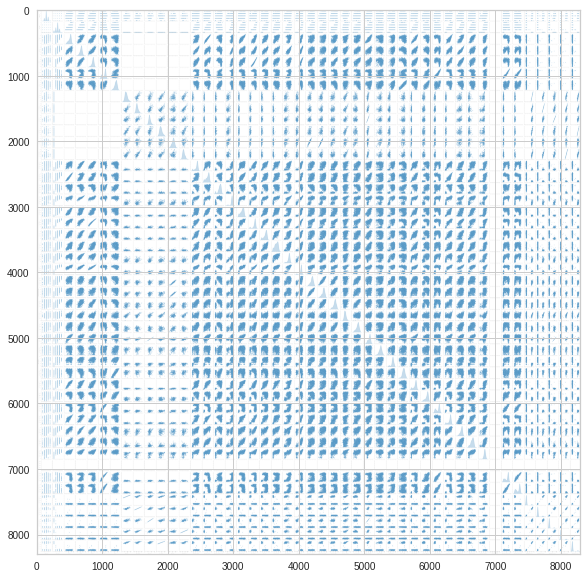

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(pairplot)

Analizamos algunos graficos en particular, considerando la posicion de juego de los jugadores:

1. `goalkeeping_handling` vs `movement_reaction`: en este caso vemos que la habilidad de "manejo de la pelota" y la reacción del jugador, tiene una relacion positiva para los arqueros pero en el caso de otras posiciones, tal como los defensores, no se observa ninguna relación. Estas dos posiciones se ubican en grupos distintos, lo que no es tan claro para delanteros y mediocampistas. 



In [ ]:
df = data_2
fig = px.scatter(df, x="movement_reactions", y="goalkeeping_handling", color="Posición")
fig.show(renderer="colab")

2. `skill_dribbling` vs `defending_sliding_tackle`: en el grafico se forman dos grupos, uno inferior en el que se concentran los arqueros (tienen bajo score de ambas habilidades ya que el dribbling es una habilidad valorada en delanteros y el sliding tackle uno de defensa). Por el contrario, los defensores se ubican en la parte superior del otro grupo ya que tienen un alto score en el sliding tackle, el resto de las posiciones se distribuye entre ambos grupos. 

In [ ]:
df = data_2
fig = px.scatter(df, x="skill_dribbling", y="defending_sliding_tackle", color="Posición")
fig.show(renderer="colab")


3. ```attacking_finishing``` vs ```shooting```(Finalización del ataque vs Disparo): se muestran dos caracteristicas tipicas de jugadores que juegan de delanteros. Se observa en el grafico que los jugadores delanteros se agrupan en la parte superior derecha del grafico, los mediocampistas abarcan casi todo el grafico ya que hay posiciones que se ubican mas cerca del ataque y otros de la defensa, mientras que los jugadores de defensa y arqueros se agrupa abajo a la izquierda ya que tienen menor score en estas habilidades. 


In [ ]:
df = data_2
fig = px.scatter(df, x="attacking_finishing", y="shooting", color="Posición")
fig.show(renderer="colab")

Lo que se obtiene de este breve analisis es que hay un indicio de que ciertas posiciones (principalmente arco o defensa) tienden a tener caracteristicas bastantes marcadas que las distinguen de las demas posiciones y se concentran, de tal manera que se los puede asociar a grupos o clusters. En las secciones siguientes se aplicaran tecnicas de clustering para identificar estos grupos.

## 3. Tecnicas de clustering y análisis de Clusters encontrados


### K-Means

El algoritmo de K-means requiere que especifiquemos el numero de clusters que genera las particiones del espacio. A priori, tenemos la intuición de que puede haber 4 grupos o clusters basado en la posicion de juego de los jugadores (o quizas menos). Sin embargo, podemos contar con un metodo denominado "Elbow method o metodo del codo" 
que compara la inercia del modelo (suma de distancias cuadradadas dentro de cada cluster de la particion final) en funcion de diferentes k (numero de clusters). Se considera que el mejor valor de k se da cuando se desacelera la reduccion de la inercia, es decir, cuando aparece un codo en el grafico. 

En el grafico se observa que partir del valor 4, los quiebres son menos pronuciados y la reduccion de la inercia se hace menor cada vez que aumentan los clusters. Por esa razón, se escoge el valor 4 como número de clusters. 

In [ ]:
# Filtramos los mejores jugadores (aquellos por encima del cuartil 75)
# Nos quedamos con las habilidades
# Los valores faltantes los imputamos con 0
data_2 = data_2[data_2["overall"] > 70]
df_skills = data_2[skills]
df_skills = df_skills._get_numeric_data()
df_skills = df_skills.fillna(0)

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

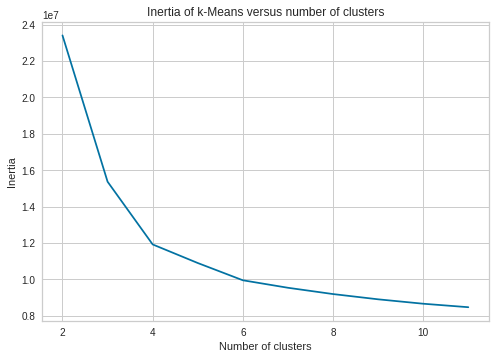

In [ ]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i).fit(df_skills).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [ ]:
# Número de clusters buscado
n_clust = 4

km = KMeans(n_clusters=n_clust, random_state = 123)
km.fit(df_skills) 

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al cluster=Inertia=  11916021.461825754


In [ ]:
#Eligo dos números entre 0 y  de n_skills-1
skill_1= "skill_dribbling"
skill_2= "defending_sliding_tackle"

In [ ]:
kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=data_2.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

data=[kmean_clusters]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=True)

fig = go.Figure(data=data, layout=layout)

fig.show(renderer="colab")

In [ ]:
df_clusters_km=data_2.copy()
df_clusters_km['kmeans'] = km.labels_ #clusters
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')

Kmeans encontró:  4 clusters, nosotros forzamos la cantidad


In [ ]:
skill_sets = ["skill_dribbling", "defending_sliding_tackle"]

K-mean encontró 4 clusters utilizando 34 variables numéricas. En la visualización, se observa la relación de dos variables analizadas anteriormente en la seccion de analisis grafico. Vemos que los jugadores se asignaron a 4 clusters bastante diferenciados. Si comparamos con el grafico anterior, en donde diferenciamos por color a la posicion, vemos que el grupo concentrado en la esquina inferior probablemente corresponda a los arqueros pero no esta tan claro respecto al resto de las posiciones. 

### Mean Shift

A diferencia del algoritmo anterior, en este caso no debemos elegir previamente el numero de k sino que lo detectara el propio algoritmo.

In [ ]:
ms = MeanShift(bandwidth=2, bin_seeding=True)

ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_mean_shift.py:249: UserWarning:

Binning data failed with provided bin_size=2.000000, using data points as seeds.



Cantidad de clusters encontrados por Mean Shift : 4422


In [ ]:
#Eligo dos números entre 0 y  de n_skills-1
skill_1= "skill_dribbling"
skill_2= "defending_sliding_tackle"

In [ ]:
MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=data_2.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

data=[MeanShift_clusters]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=True)

fig = go.Figure(data=data, layout=layout)

fig.show(renderer="colab")

La interpretacion del grafico se hace mucho mas complicada ya que existen 4422 grupos (cuando el dataset tiene 4423 registros) por lo que solo un jugador se ubica junto con otro, el resto de conforma el grupo indivualmente.  

In [ ]:
df_clusters_ms=data_2.copy()
df_clusters_ms['kmeans'] = ms.labels_ #clusters

### Jerarquico

In [ ]:
cluster = AgglomerativeClustering(affinity='cityblock', linkage= 'average', n_clusters= None, distance_threshold = 1000)
cluster.fit(df_skills)

clusters2 = cluster.labels_
cluster_centers = cluster.n_clusters_

labels_unique = np.unique(clusters2)
n_clusters = len(labels_unique)

print("Cantidad de clusters encontrados: %d" % n_clusters)

Cantidad de clusters encontrados: 2


In [ ]:
data=[]
complete_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=data_2.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

data=[complete_clusters]

layout = go.Layout(title="Complete CityBlock Agglomerative",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=True)

fig = go.Figure(data=data, layout=layout)

fig.show(renderer="colab")

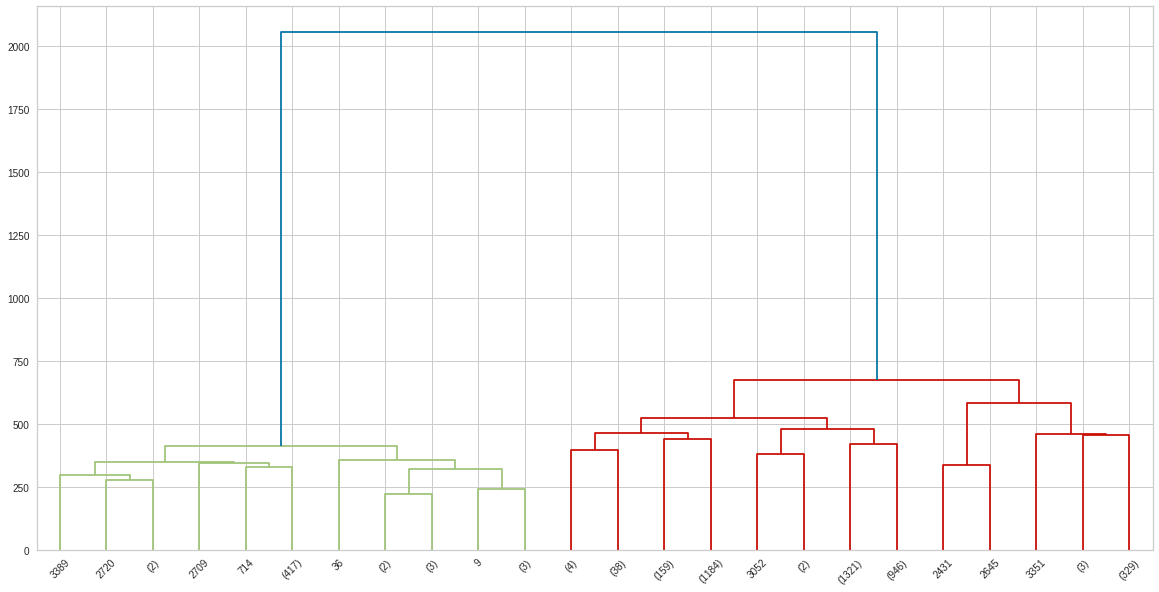

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


plt.figure(figsize=(20, 10))
plot_dendrogram(cluster, truncate_mode='level', p=4)

Al aplicar el método jerárquico con vinculación promedio, se utilizo el gráfico "dendrograma" para determinar la cantidad óptima de clusters. En este sentido uno debe "detener la fusión de conglomerados cuando los grupos que se han de unir están a una distancia significaticamente mayor de los que previamente se han fusionado" (Jiménez E., Aldas Manzano E., 2005)*. 

Tal como se observa en el gráfico, esto sucede cuando se fusionan los grupos determinando dos grandes conglomerados (el grupo "rojo" y el grupo "verde"). Probablemente, estos dos grupos correspondan, uno a los arqueros y el resto de las posiciones (ya que es la posicion de juego que tiene caracteristicas mas distintivas). 

Es decir, existen claramente dos grupos, definiendo un threshold a partir de 750 aproximadamente. Si disminuimos el valor del limite, podemos llegar a 3 grupos pero luego, ya se determinarian muchos mas.

---
*Jiménez E. Aldas Manzano E. (2005). Análisis multivariante aplicado. 

In [ ]:
df_clusters_ac=data_2.copy()
df_clusters_ac['kmeans'] = cluster.labels_ #clusters

## 5. Embeddings y Tecnicas de Clustering

In [ ]:
n_sne=2000 #elegir numero pequeño para agilidad en el cálculo luego
df_sne=data_2.loc[:n_sne]
X=df_skills.loc[:n_sne]
print('dimensión del espacio de los datos: ', len(df_skills.columns))

dimensión del espacio de los datos:  48


La aplicación de tsne permite transformar el espacio de 48 dimensiones en 2 dimensiones. 

In [ ]:
time_start = time.time()

tsne = manifold.TSNE(n_components=2, verbose=1,perplexity=30, n_iter=1000,  random_state=123)
X_tsne = tsne.fit_transform(X)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1960 samples in 0.000s...
[t-SNE] Computed neighbors for 1960 samples in 0.160s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computed conditional probabilities for sample 1000 / 1960
[t-SNE] Computed conditional probabilities for sample 1960 / 1960
[t-SNE] Mean sigma: 16.511768
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.149734
[t-SNE] KL divergence after 1000 iterations: 1.296231
t-SNE done! Time elapsed: 14.157404661178589 seconds


Visualizamos las dos componentes construidas graficamente

In [ ]:
data=[]
#graficamos los datos en el espacio transformado: las dos componentes tsne
graf1 = go.Scatter(x=X_tsne[:,0], y=X_tsne[:,1],
                           mode='markers',
                        text=df_sne.loc[:,'Posición'],
                           marker=dict(
                                size=5)
                           )
data=[graf1]

layout = go.Layout(title="Visualización de la base en el espacio tsne",titlefont=dict(size=20),
                xaxis=dict(title='componente 1'),
                yaxis=dict(title='componente 2'),
                autosize=True)

fig = go.Figure(data=data, layout=layout)

fig.show(renderer="colab")

Al reducir dimensionalidad se pierde interpretabilidad en terminos de los componentes que se obtuvieron.

En el gráfico se observan dos grupos muy diferenciados. Al indicar la posición vemos que en el grupo mas separado se concentran los arqueros ya que, por lo que hemos visto en análisis previos, presentan habilidades distintas del resto de los jugadores. 

**Técnicas de Clustering.** Aplicamos ahora la técnica de klustering Mean Shift para analizar cuantos clusters se encuentran en este espacio reducido a dos dimensiones (recordemos que en el espacio original, este algoritmo encontraba más de 4000 clusters). 

In [ ]:
ms_tsne = MeanShift(bandwidth=2, bin_seeding=True)

ms_tsne.fit(X_tsne)

clusters_tsne = ms_tsne.labels_
cluster_centers_tsne = ms_tsne.cluster_centers_

labels_unique = np.unique(clusters_tsne)
n_clusters_tsne = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_tsne)

Cantidad de clusters encontrados por Mean Shift : 270


In [ ]:
MeanShift_clusters = go.Scatter(x =X_tsne[:,0], y=X_tsne[:,1],
                           mode='markers',
                        text=df_sne.loc[:,'Posición'],
                           marker=dict(
                                size=5,
                                color = clusters_tsne.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

data=[MeanShift_clusters]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title="componente1"),
                yaxis=dict(title="componente2"),
                autosize=True)

fig = go.Figure(data=data, layout=layout)

fig.show(renderer="colab")

Si bien la cantidad de clusters encontrados se ha reducido, de 4200 aproximadamente en el espacio de habilidades inicial a 311 en el espacio reducido de dos componentes, no hay demasiados puntos concentrados en pocos grupos sino que van formando pequeños grupitos en el gráfico. 

## 6. Evaluación 

**La evaluación se realiza sobre las técnicas de clustering aplicadas al espacio de habilidades original. 

En esta sección se presenta:
* Cantidad de observaciones por cluster. 
* Análisis descriptivo separando por cluster. 
* Tabla de contingencia de posición vs cluster.
* Análisis de siluetas para K-Means(Silhouette analysis). Se utiliza para estudiar la separacion que existe entre los clusters encontrados. Lo ideal es encontrar que las siluetas esten balanceadas, lo que indicaria que el numero k de clusters encontrados es bueno. 

### K-Means

*Cant. de observaciones por cluster encontrado*

In [ ]:
# Cantidad de observaciones por cluster
df_clusters_km["kmeans"].value_counts()

2    1630
3    1448
0     912
1     433
Name: kmeans, dtype: int64

*Análisis descriptivo por cluster encontrado*

In [ ]:
df_clusters_km.groupby("kmeans").describe()

sofifa_id                                        ... goalkeeping_reflexes                  
           count           mean           std      min  ...                  25%   50%   75%   max
kmeans                                                  ...                                       
0          912.0  212143.177632  24419.505510  20209.0  ...                  8.0  11.0  13.0  51.0
1          433.0  196742.302540  35315.929854   1179.0  ...                 74.0  76.0  80.0  90.0
2         1630.0  209973.814724  24092.065240     41.0  ...                  8.0  10.0  13.0  46.0
3         1448.0  211188.480663  27225.421028   3467.0  ...                  8.0  10.0  13.0  37.0

[4 rows x 496 columns]

*Cant. de observaciones de cada posición por cluster encontrado*

* Ninguno de los clusters contiene unicamente jugadores de una única posición de juego.
* Todos los arqueros se ubican en el cluster 1, junto a algunos jugadores de otras posición. 

In [ ]:
# Tabla de contingencia por Posicion y Cluster asignado
data_crosstab = pd.crosstab(df_clusters_km['kmeans'],  df_clusters_km['Posición'], margins = False) 
data_crosstab

Posición,D,GK,MF,S
kmeans,,,,
0,557,0,73,282
1,0,293,21,119
2,606,0,463,561
3,8,0,469,971


*Análisis de Siluetas*

Tres de las siluetas se encuentran bastante cerca del promedio, lo que es un buen indicio de homogeneidad de los clusters encontrados, pero existe una de las siluetas que se encuentra distanciada. Esto indica que k = 4 no es el número más apropiado. 

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



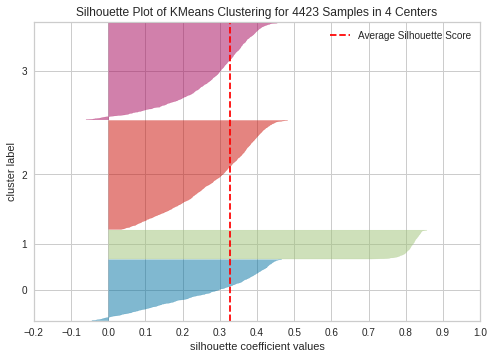

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

model = km
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(df_skills)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Mean Shift

La evaluación de este algoritmo es más complicada ya que existen tantos clusters como registros en el conjunto de datos.

*Cant. de observaciones por cluster encontrado*

In [ ]:
# Cantidad de observaciones por cluster
df_clusters_ms["kmeans"].value_counts()

0       2
577     1
565     1
2616    1
569     1
       ..
1302    1
3347    1
1298    1
3343    1
4096    1
Name: kmeans, Length: 4422, dtype: int64

*Análisis descriptivo por cluster encontrado*

In [ ]:
df_clusters_ms.groupby("kmeans").describe()

sofifa_id                                   ... goalkeeping_reflexes                  
           count      mean          std       min  ...                  25%   50%   75%   max
kmeans                                             ...                                       
0            2.0  231741.5  2064.044694  230282.0  ...                 12.0  12.0  12.0  12.0
1            1.0  190871.0          NaN  190871.0  ...                 11.0  11.0  11.0  11.0
2            1.0  231443.0          NaN  231443.0  ...                 13.0  13.0  13.0  13.0
3            1.0  139068.0          NaN  139068.0  ...                  6.0   6.0   6.0   6.0
4            1.0  156616.0          NaN  156616.0  ...                 10.0  10.0  10.0  10.0
...          ...       ...          ...       ...  ...                  ...   ...   ...   ...
4417         1.0  226285.0          NaN  226285.0  ...                 74.0  74.0  74.0  74.0
4418         1.0  215363.0          NaN  215363.0  ...                 76.0  76.0  76.0  76.0
4419         1.0  217813.0          NaN  217813.0  ...                 74.0  74.0  74.0  74.0
4420         1.0  230525.0          NaN  230525.0  ...                 75.0  75.0  75.0  75.0
4421         1.0  149258.0          NaN  149258.0  ...                 74.0  74.0  74.0  74.0

[4422 rows x 496 columns]

*Cant. de observaciones de cada posición por cluster encontrado*

In [ ]:
# Tabla de contingencia por Posicion y Cluster asignado
data_crosstab = pd.crosstab(df_clusters_ms['kmeans'],  df_clusters_ms['Posición'], margins = False) 
data_crosstab

Posición,D,GK,MF,S
kmeans,,,,
0,2,0,0,0
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
4417,0,1,0,0
4418,0,1,0,0
4419,0,0,0,1


### Jerarquico

*Cant. de observaciones por cluster encontrado*

In [ ]:
# Cantidad de observaciones por cluster
df_clusters_ac["kmeans"].value_counts()

0    3990
1     433
Name: kmeans, dtype: int64

*Análisis descriptivo por cluster encontrado*

In [ ]:
df_clusters_ac.groupby("kmeans").describe()

sofifa_id                                       ... goalkeeping_reflexes                  
           count           mean           std     min  ...                  25%   50%   75%   max
kmeans                                                 ...                                       
0         3990.0  210910.480201  25354.025322    41.0  ...                  8.0  10.0  13.0  51.0
1          433.0  196742.302540  35315.929854  1179.0  ...                 74.0  76.0  80.0  90.0

[2 rows x 496 columns]

*Cant. de observaciones de cada posición por cluster encontrado*

* La agrupación en el cluster 1 es la misma que en K-means.

In [ ]:
# Tabla de contingencia por Posicion y Cluster asignado
data_crosstab = pd.crosstab(df_clusters_ac['kmeans'],  df_clusters_ac['Posición'], margins = False) 
data_crosstab

Posición,D,GK,MF,S
kmeans,,,,
0,1171,0,1005,1814
1,0,293,21,119


## 7. Preguntas 

**¿Se realizó alguna normalización de la base? ¿Por qué ?**

No se normalizo la base. Esto se debe a que la magnitud de las variables de habilidades es igual (de 0 a 100) por lo que no hay diferencias en sus escalas y no habria problema para buscar clusters tomando en cuenta todas estas variables.